# Polynomial Regression
This notebook is used to experiment with overfitting, underfitting, data distribution, noise, and cross-validation in polynomial regression.

In [2]:
import numpy as np
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from numpy.random import rand, randn

In [3]:
def generate_data(p, beta, sig, n):
    """
     Generates data for polynomial regression.

     Args:
       p (int): Degree of the polynomial for data generation.
       beta (np.array): A column vector of the true polynomial coefficients [b_0, b_1, ..., b_p].T.
       sig (float): The standard deviation of the Gaussian noise (spread of the data).
       n (int): The number of data points to generate.

    Returns:
      tuple: A tuple containing:
        - u (np.array): A column vector of the independent variable values.
        - y (np.array): A column vector of the dependent variable values.

    """
    # Generate n feature values uniformly from [0, 1]
    u = np.random.rand(n, 1)

    # Generate the dependent variable values using the polynomial model with added Gaussian noise
    y = (u ** np.arange(0, p + 1)) @ beta + sig * np.random.randn(n, 1)
    return u, y

   

In [4]:
def model_matrix(p, u):
    """
    Constructs the design matrix (model matrix) for polynomial regression.

    Args:
       p (int): The degree of the polynomial model to be fitted.
       u (np.array): An (n, 1) array of feature values.

    Returns:
       np.array: An (n, p+1) design matrix X, where each column is u^j for j=0, ..., p.
    """
    n = len(u)  # fixed bug, n was undefined

    X = np.ones((n, 1))
    p_range = np.arange(0, p + 1)
    for p_current in p_range:
        if p_current > 0:
            X = np.hstack((X, u ** (p_current)))
    return X


In [5]:
def train(X, y):
    """
    Trains a linear regression model using the normal equation.

    Args:
        X (np.array): The design matrix of shape (n, p+1).
        y (np.array): The target values of shape (n, 1).

    Returns:
        np.array: The estimated coefficients (betahat) of shape (p+1, 1).
    """
    betahat = solve(X.T @ X, X.T @ y)
    return betahat

def test_coefficients(n, betahat, X, y):
    """
    Calculates the Mean Squared Error (MSE) loss for a given model.

    Args:
        n (int): The number of data points.
        betahat (np.array): The estimated model coefficients.
        X (np.array): The design matrix.
        y (np.array): The true target values.

    Returns:
        float: The mean squared error loss.
    """

    y_hat = X @ betahat
    loss = norm(y - y_hat) ** 2 / n
    return loss

In [6]:
def linear_cv(K, n, X, y):
    """
    Performs K-fold cross-validation for polynomial regression.
    
    Args:
        K (int): The number of folds for cross-validation.
        n (int): The total number of samples.
        X (np.array): The design matrix of shape (n, p+1).
        y (np.array): The target values of shape (n, 1).

    Returns:
        float: The average cross-validation loss across all folds.
    """
    loss = []
    for k in range(1, K + 1):
        # integer indices of test samples
        test_ind = ((n / K) * (k - 1) + np.arange(1, n / K + 1) - 1).astype("int")
        train_ind = np.setdiff1d(np.arange(n), test_ind)

        X_train, y_train = X[train_ind, :], y[train_ind, :]
        X_test, y_test = X[test_ind, :], y[test_ind]

        # fit model and evaluate test loss
        betahat = train(X_train, y_train)
        loss.append(test_coefficients(n, betahat, X_test, y_test))
        cv = sum(loss) / n
    return cv

#### Experiment: Overfitting & Underfitting

A replication of the initial experiment in the polynomial_regression.py

Training Loss: {1: np.float64(48.96321743465423), 3: np.float64(18.64219298349325), 15: np.float64(16.773422935704318)}
Test Loss: {1: np.float64(47.3033524623494), 3: np.float64(24.60169633475586), 15: np.float64(27.060618468634633)}


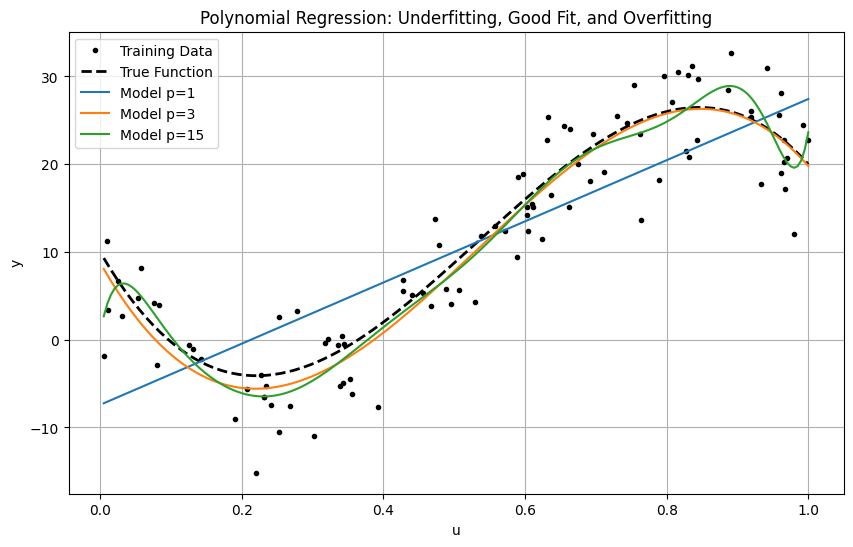

In [11]:
# Parameters to adjust for experiments
beta = np.array([[10, -140, 400, -250]]).T  # degree 3
n = 100
sig = 5

# Generate training data
u, y = generate_data(3, beta, sig, n)

# Train models
X, betahat = {}, {}
ps = [1, 3, 15]
for p in ps:
    X[p] = model_matrix(p, u)
    betahat[p] = train(X[p], y)

# Test on new data
u_test, y_test = generate_data(3, beta, sig, n)


X_test = {}
training_loss = {}
test_loss = {}
for p in ps:
    X_test[p] = model_matrix(p, u_test)
    training_loss[p] = test_coefficients(n, betahat[p], X[p], y)
    test_loss[p] = test_coefficients(n, betahat[p], X_test[p], y_test)


# print the losses to see them
print("Training Loss:", training_loss)
print("Test Loss:", test_loss)

# Plot the points and true line and store in the list "plots"
xx = np.arange(np.min(u), np.max(u) + 5e-3, 5e-3)
yy_true = np.polyval(np.flip(beta), xx)

# plots = [plt.plot(u, y, "k.", markersize=8)[0], plt.plot(xx, yy, "k--", linewidth=3)[0]]

plt.figure(figsize=(10,6))
plt.plot(u, y, "k.", label="Training Data")
plt.plot(xx, yy_true, "k--", linewidth=2, label="True Function")

# add the three curves
for i , p in enumerate(ps):
    yy_pred = np.polyval(np.flip(betahat[p]), xx)
    plt.plot(xx, yy_pred, label=f"Model p={p}")


plt.xlabel("u")
plt.ylabel("y")
plt.title("Polynomial Regression: Underfitting, Good Fit, and Overfitting")
plt.legend()
plt.grid(True)
plt.show()

### Observation

When running the experiment with the corrected code, the plot clearly illustrates the concepts of underfitting, a good fit, and overfitting. The true data is generated from a 3rd-degree polynomial (p=3). 

p = 1 (Underfitting): The model is a straight line and is too simple to capture the curve in the data. Its capacity is too low. This results in high bias, meaning the model is systematically wrong, leading to high error on both training and test sets. 


p = 3 (Good Fit): The model's complexity matches the data's underlying structure. It captures the general trend without being overly influenced by random noise. This model has a good bias-variance balance. 


p = 15 (Overfitting): The model is excessively complex. It has so much flexibility that it fits the random noise in the training data, not just the true signal. This results in high variance. The model performs exceptionally well on the training data it has seen, but it generalizes poorly to new, unseen data, leading to a high test error

#### Experiment 2: Varying Datasets

Varying the Order of the Polynomial Used to Generate the Data

Training Loss (p_true = 5):
p=1: 33.3952
p=3: 26.1465
p=5: 24.8533
p=15: 23.9369

Test Loss (p_true = 5):
p=1: 34.0613
p=3: 29.7492
p=5: 32.4594
p=15: 35.1389


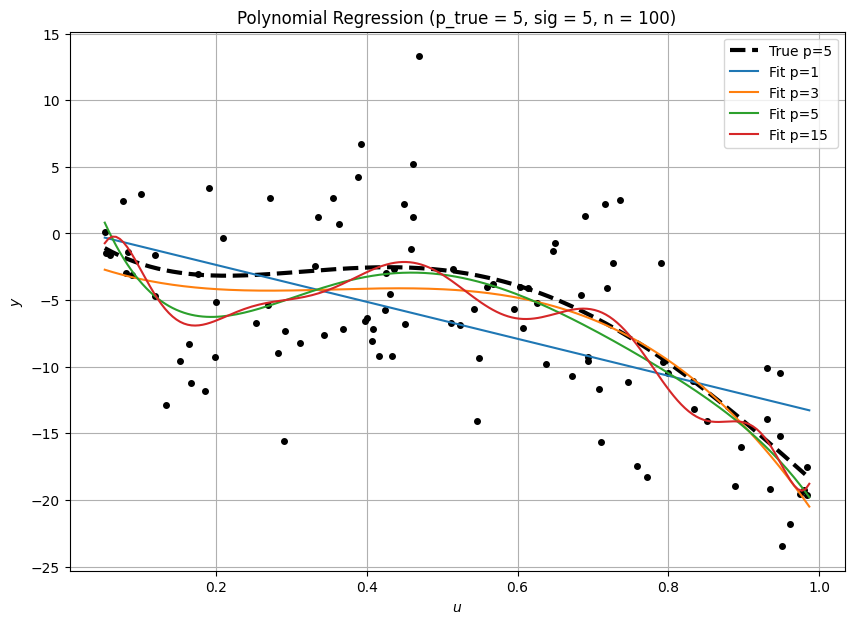

In [ ]:
# Define the true beta for p_true = 5
# Ensure the length of beta_true_B is p_true + 1 = 6
beta_true_B = np.array([[1, -50, 200, -300, 150, -20]]).T 

# Keeping n and sig as initial values for now
n = 100
sig = 5

# Generate training data with p_true = 5
u_train_p5, y_train_p5 = generate_data(5, beta_true_B, sig, n)

# Generate test data with p_true = 5 (from the same distribution)
u_test_p5, y_test_p5 = generate_data(5, beta_true_B, sig, n)

# Model complexities to test
ps = [1, 3, 5, 15] # Add 5 to see the 'good fit' for this p_true

X_models_p5, betahat_models_p5 = {}, {}
training_loss_p5 = {}
test_loss_p5 = {}
X_test_models_p5 = {}

for p in ps:
   # Train models on the generated training data
   X_models_p5[p] = model_matrix(p, u_train_p5)
   betahat_models_p5[p] = train(X_models_p5[p], y_train_p5)

   # Evaluate training loss
   training_loss_p5[p] = test_coefficients(
       len(y_train_p5), betahat_models_p5[p], X_models_p5[p], y_train_p5
   )

   # Prepare test model matrices and evaluate test loss
   X_test_models_p5[p] = model_matrix(p, u_test_p5)
   test_loss_p5[p] = test_coefficients(
       len(y_test_p5), betahat_models_p5[p], X_test_models_p5[p], y_test_p5
   )

print("Training Loss (p_true = 5):")
for p in ps:
    print(f"p={p}: {training_loss_p5[p]:.4f}")
print("\nTest Loss (p_true = 5):")
for p in ps:
    print(f"p={p}: {test_loss_p5[p]:.4f}")

# Plotting for p_true = 5
plt.figure(figsize=(10, 7))
xx = np.arange(np.min(u_train_p5), np.max(u_train_p5) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_p5 = (xx ** np.arange(0, beta_true_B.shape[0])) @ beta_true_B
plots = [
    plt.plot(u_train_p5, y_train_p5, "k.", markersize=8)[0],
    plt.plot(xx, yy_true_p5, "k--", linewidth=3, label="True p=5")[0],
]

for i in ps:
    yy_fitted_p5 = (xx ** np.arange(0, betahat_models_p5[i].shape[0])) @ betahat_models_p5[i]
    plots.append(plt.plot(xx, yy_fitted_p5, label=f"Fit p={i}")[0])

plt.xlabel(r"$u$")
plt.ylabel(r"$y$")
plt.title(f"Polynomial Regression (p_true = 5, sig = {sig}, n = {n})")
plt.legend()
plt.grid(True)
plt.show()


Varying the Spread of the Data (values of sig)

Training Loss (sig = 0):
p=1: 16.8357
p=3: 0.0000
p=15: 0.0000

Test Loss (sig = 0):
p=1: 27.8668
p=3: 0.0000
p=15: 0.0000


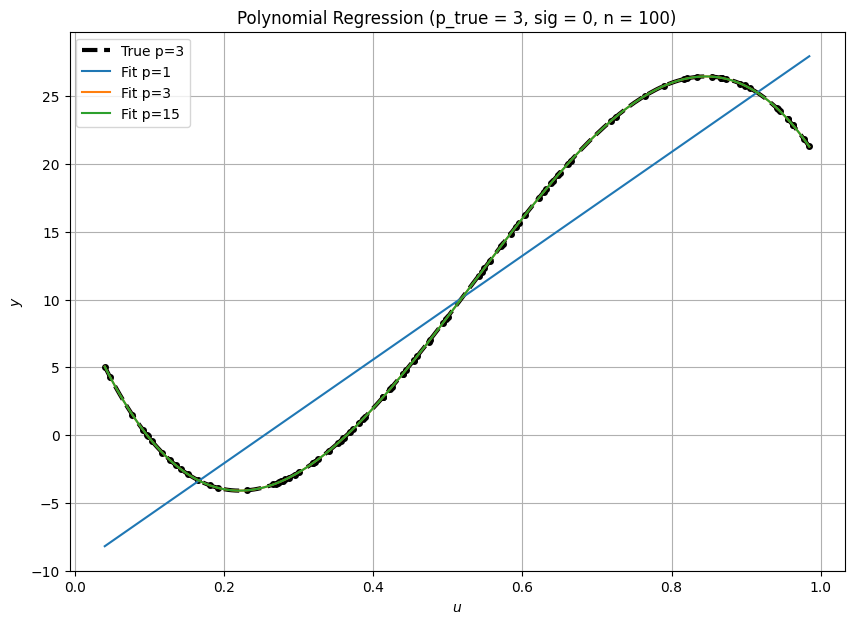

In [14]:

# Original p_true (e.g., 3) and beta for data generation
beta_orig = np.array([[10, -140, 400, -250]]).T
p_true = 3
n = 100
sig_deterministic = 0 # Deterministic case

# Generate training data
u_train_sig0, y_train_sig0 = generate_data(p_true, beta_orig, sig_deterministic, n)

# Generate test data (from the same deterministic distribution)
u_test_sig0, y_test_sig0 = generate_data(p_true, beta_orig, sig_deterministic, n)

ps = [1, 3, 15] # Model complexities

X_models_sig0, betahat_models_sig0 = {}, {}
training_loss_sig0 = {}
test_loss_sig0 = {}
X_test_models_sig0 = {}

for p in ps:
   X_models_sig0[p] = model_matrix(p, u_train_sig0)
   betahat_models_sig0[p] = train(X_models_sig0[p], y_train_sig0)
   training_loss_sig0[p] = test_coefficients(len(y_train_sig0), betahat_models_sig0[p], X_models_sig0[p], y_train_sig0)

   X_test_models_sig0[p] = model_matrix(p, u_test_sig0)
   test_loss_sig0[p] = test_coefficients(len(y_test_sig0), betahat_models_sig0[p], X_test_models_sig0[p], y_test_sig0)

print("Training Loss (sig = 0):")
for p in ps:
    print(f"p={p}: {training_loss_sig0[p]:.4f}")
print("\nTest Loss (sig = 0):")
for p in ps:
    print(f"p={p}: {test_loss_sig0[p]:.4f}")

# Plotting for sig = 0
plt.figure(figsize=(10, 7))
xx = np.arange(np.min(u_train_sig0), np.max(u_train_sig0) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_sig0 = (xx ** np.arange(0, beta_orig.shape[0])) @ beta_orig
plots = [
    plt.plot(u_train_sig0, y_train_sig0, "k.", markersize=8)[0],
    plt.plot(xx, yy_true_sig0, "k--", linewidth=3, label=f"True p={p_true}")[0],
]

for i in ps:
    yy_fitted_sig0 = (xx ** np.arange(0, betahat_models_sig0[i].shape[0])) @ betahat_models_sig0[i]
    plots.append(plt.plot(xx, yy_fitted_sig0, label=f"Fit p={i}")[0])

plt.xlabel(r"$u$")
plt.ylabel(r"$y$")
plt.title(f"Polynomial Regression (p_true = {p_true}, sig = {sig_deterministic}, n = {n})")
plt.legend()
plt.grid(True)
plt.show()

Scenario B: Increased noise ( sig = 20)

Training Loss (sig = 20):
p=1: 397.5059
p=3: 364.4446
p=15: 342.6411

Test Loss (sig = 20):
p=1: 410.7359
p=3: 383.6624
p=15: 430.8539


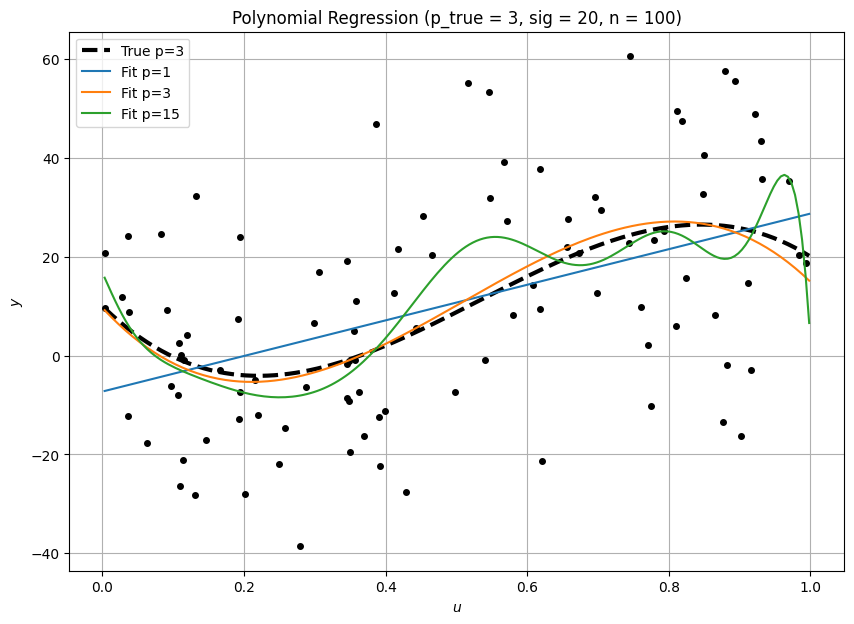

In [15]:
beta_orig = np.array([[10, -140, 400, -250]]).T
p_true = 3
n = 100
sig_high = 20 # High noise

u_train_high_sig, y_train_high_sig = generate_data(p_true, beta_orig, sig_high, n)
u_test_high_sig, y_test_high_sig = generate_data(p_true, beta_orig, sig_high, n)

ps = [1, 3, 15]

X_models_high_sig, betahat_models_high_sig = {}, {}
training_loss_high_sig = {}
test_loss_high_sig = {}
X_test_models_high_sig = {}

for p in ps:
   X_models_high_sig[p] = model_matrix(p, u_train_high_sig)
   betahat_models_high_sig[p] = train(X_models_high_sig[p], y_train_high_sig)
   training_loss_high_sig[p] = test_coefficients(len(y_train_high_sig), betahat_models_high_sig[p], X_models_high_sig[p], y_train_high_sig)

   X_test_models_high_sig[p] = model_matrix(p, u_test_high_sig)
   test_loss_high_sig[p] = test_coefficients(len(y_test_high_sig), betahat_models_high_sig[p], X_test_models_high_sig[p], y_test_high_sig)

print("Training Loss (sig = 20):")
for p in ps:
    print(f"p={p}: {training_loss_high_sig[p]:.4f}")
print("\nTest Loss (sig = 20):")
for p in ps:
    print(f"p={p}: {test_loss_high_sig[p]:.4f}")

# Plotting for sig = 20
plt.figure(figsize=(10, 7))
xx = np.arange(np.min(u_train_high_sig), np.max(u_train_high_sig) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_high_sig = (xx ** np.arange(0, beta_orig.shape[0])) @ beta_orig
plots = [
    plt.plot(u_train_high_sig, y_train_high_sig, "k.", markersize=8)[0],
    plt.plot(xx, yy_true_high_sig, "k--", linewidth=3, label=f"True p={p_true}")[0],
]

for i in ps:
    yy_fitted_high_sig = (xx ** np.arange(0, betahat_models_high_sig[i].shape[0])) @ betahat_models_high_sig[i]
    plots.append(plt.plot(xx, yy_fitted_high_sig, label=f"Fit p={i}")[0])

plt.xlabel(r"$u$")
plt.ylabel(r"$y$")
plt.title(f"Polynomial Regression (p_true = {p_true}, sig = {sig_high}, n = {n})")
plt.legend()
plt.grid(True)
plt.show()

The data points are much more scattered around the true polynomial curve.

The test error for all models significantly increases, as there's more inherent noise that cannot be predicted.

The danger of overfitting increases dramatically, as complex models have more "randomness" to latch onto. The 

p=15 model shows a very large gap between its low training loss and its much higher test loss, with extremely erratic behavior in the plot. The 

p=3 model still generally perform best, but its performance is poorer than in lower-noise scenarios.

## Varying Number of Data Points

Training Loss (n = 20):
p=1: 16.5184
p=3: 10.5591
p=15: 3.0972

Test Loss (n = 20):
p=1: 42.4740
p=3: 29.5853
p=15: 876727.5913


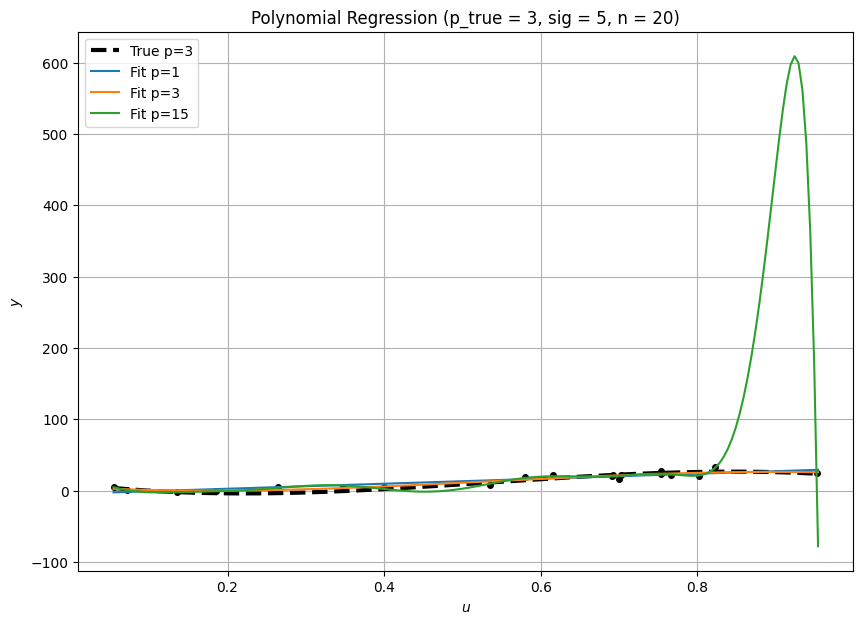

In [17]:
# Experiment: Varying N (n = 20 - Very Low Data)

beta_orig = np.array([[10, -140, 400, -250]]).T
p_true = 3
sig = 5
n_low = 20 # Very low data points

u_train_n_low, y_train_n_low = generate_data(p_true, beta_orig, sig, n_low)
u_test_n_low, y_test_n_low = generate_data(p_true, beta_orig, sig, n_low)

ps = [1, 3, 15]

X_models_n_low, betahat_models_n_low = {}, {}
training_loss_n_low = {}
test_loss_n_low = {}
X_test_models_n_low = {}

for p in ps:
   X_models_n_low[p] = model_matrix(p, u_train_n_low)
   betahat_models_n_low[p] = train(X_models_n_low[p], y_train_n_low)
   training_loss_n_low[p] = test_coefficients(len(y_train_n_low), betahat_models_n_low[p], X_models_n_low[p], y_train_n_low)

   X_test_models_n_low[p] = model_matrix(p, u_test_n_low)
   test_loss_n_low[p] = test_coefficients(len(y_test_n_low), betahat_models_n_low[p], X_test_models_n_low[p], y_test_n_low)

print("Training Loss (n = 20):")
for p in ps:
    print(f"p={p}: {training_loss_n_low[p]:.4f}")
print("\nTest Loss (n = 20):")
for p in ps:
    print(f"p={p}: {test_loss_n_low[p]:.4f}")

# Plotting for n = 20
plt.figure(figsize=(10, 7))
xx = np.arange(np.min(u_train_n_low), np.max(u_train_n_low) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_n_low = (xx ** np.arange(0, beta_orig.shape[0])) @ beta_orig
plots = [
    plt.plot(u_train_n_low, y_train_n_low, "k.", markersize=8)[0],
    plt.plot(xx, yy_true_n_low, "k--", linewidth=3, label=f"True p={p_true}")[0],
]

for i in ps:
    yy_fitted_n_low = (xx ** np.arange(0, betahat_models_n_low[i].shape[0])) @ betahat_models_n_low[i]
    plots.append(plt.plot(xx, yy_fitted_n_low, label=f"Fit p={i}")[0])

plt.xlabel(r"$u$")
plt.ylabel(r"$y$")
plt.title(f"Polynomial Regression (p_true = {p_true}, sig = {sig}, n = {n_low})")
plt.legend()
plt.grid(True)
plt.show()

#### Scenarion B: n = 1000

Training Loss (n = 1000):
p=1: 50.9954
p=3: 25.3996
p=15: 25.0566

Test Loss (n = 1000):
p=1: 49.5146
p=3: 23.7589
p=15: 24.0070


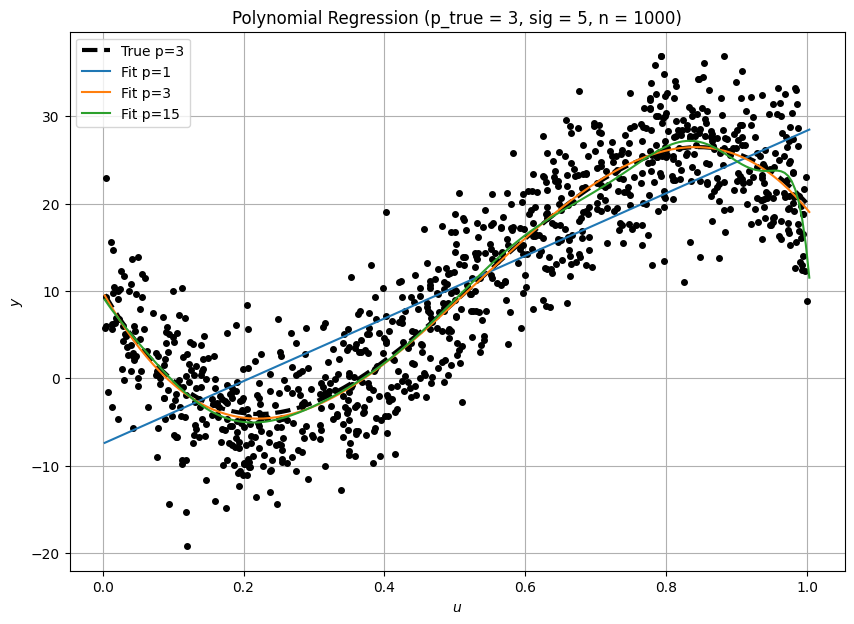

In [18]:
# Experiment: Varying N (n = 1000 - High Data)

beta_orig = np.array([[10, -140, 400, -250]]).T
p_true = 3
sig = 5
n_high = 1000 # High data points

u_train_n_high, y_train_n_high = generate_data(p_true, beta_orig, sig, n_high)
u_test_n_high, y_test_n_high = generate_data(p_true, beta_orig, sig, n_high)

ps = [1, 3, 15]

X_models_n_high, betahat_models_n_high = {}, {}
training_loss_n_high = {}
test_loss_n_high = {}
X_test_models_n_high = {}

for p in ps:
   X_models_n_high[p] = model_matrix(p, u_train_n_high)
   betahat_models_n_high[p] = train(X_models_n_high[p], y_train_n_high)
   training_loss_n_high[p] = test_coefficients(len(y_train_n_high), betahat_models_n_high[p], X_models_n_high[p], y_train_n_high)

   X_test_models_n_high[p] = model_matrix(p, u_test_n_high)
   test_loss_n_high[p] = test_coefficients(len(y_test_n_high), betahat_models_n_high[p], X_test_models_n_high[p], y_test_n_high)

print("Training Loss (n = 1000):")
for p in ps:
    print(f"p={p}: {training_loss_n_high[p]:.4f}")
print("\nTest Loss (n = 1000):")
for p in ps:
    print(f"p={p}: {test_loss_n_high[p]:.4f}")

# Plotting for n = 1000
plt.figure(figsize=(10, 7))
xx = np.arange(np.min(u_train_n_high), np.max(u_train_n_high) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_n_high = (xx ** np.arange(0, beta_orig.shape[0])) @ beta_orig
plots = [
    plt.plot(u_train_n_high, y_train_n_high, "k.", markersize=8)[0],
    plt.plot(xx, yy_true_n_high, "k--", linewidth=3, label=f"True p={p_true}")[0],
]

for i in ps:
    yy_fitted_n_high = (xx ** np.arange(0, betahat_models_n_high[i].shape[0])) @ betahat_models_n_high[i]
    plots.append(plt.plot(xx, yy_fitted_n_high, label=f"Fit p={i}")[0])

plt.xlabel(r"$u$")
plt.ylabel(r"$y$")
plt.title(f"Polynomial Regression (p_true = {p_true}, sig = {sig}, n = {n_high})")
plt.legend()
plt.grid(True)
plt.show()

Observations for Varying n:

- Low n (e.g., 20):

Models, especially high-degree ones (p=15), are highly prone to overfitting. With very few data points, a complex model can easily pass through every point (resulting in near-zero training loss) but shows a very high test loss due to poor generalization. 

- High n (e.g., 500-1000):

Overfitting becomes less severe for a given model complexity. With more data, the high-degree polynomial (p=15) has more points to fit, making it harder to perfectly fit all the noise. Its test loss decreases and become closer to the p=3 model's test loss.

The estimated coefficients for the higher-order terms in the overfit model (p=15) become smaller, as the model is "regularized" by the larger amount of data.

The test loss for the good-fit model (p=3) generally decreases and becomes more stable as n increases, as the estimated coefficients become more accurate.

### Different Feature Value Distributions

Training Loss (OOD Test):
p=1: 54.2206
p=3: 23.0524
p=15: 20.9456

Test Loss (OOD Test):
p=1: 101042.7068
p=3: 528.2025
p=15: 62029548608361365504.0000


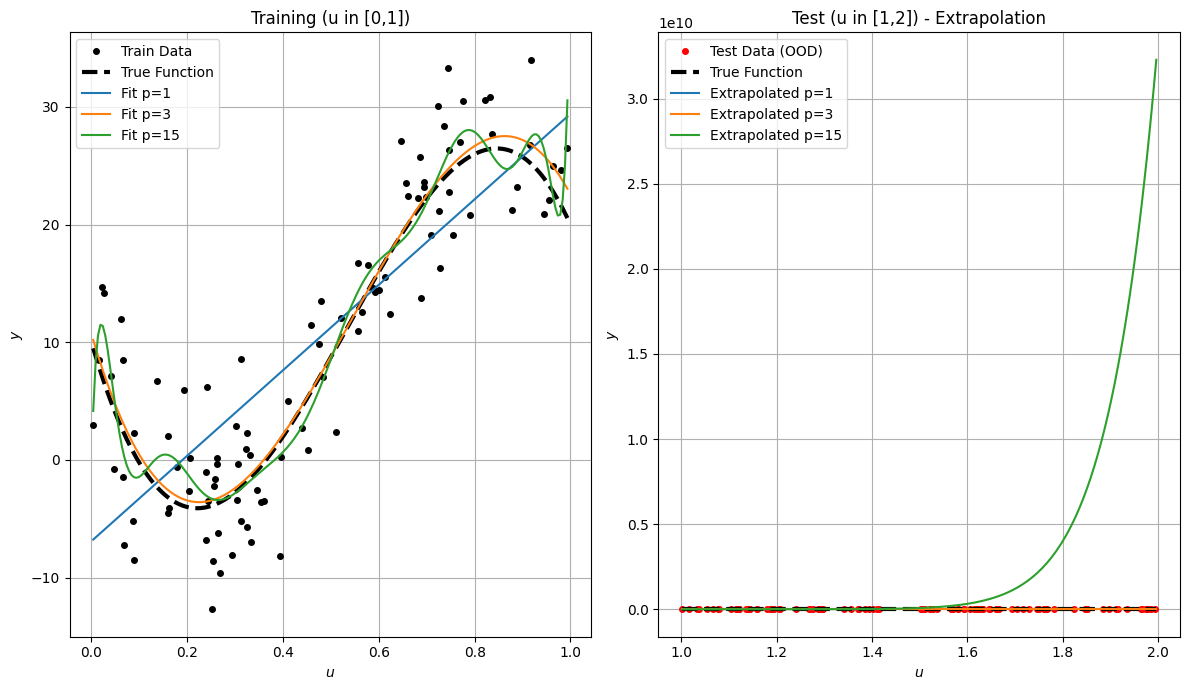

In [ ]:
# Experiment: Out-of-Distribution (OOD) Testing

beta_orig = np.array([[10, -140, 400, -250]]).T
p_true = 3
sig = 5
n = 100

# Generate TRAINING data with u uniformly from [0, 1]
u_train_ood, y_train_ood = generate_data(p_true, beta_orig, sig, n)

# Generate TEST data with u from a different interval, e.g., [1, 2]
u_test_ood = np.random.rand(n, 1) + 1 # u values from 1 to 2
y_test_ood = (u_test_ood ** np.arange(0, p_true + 1)) @ beta_orig + sig * np.random.randn(n, 1)

ps = [1, 3, 15]

X_models_ood, betahat_models_ood = {}, {}
training_loss_ood = {}
test_loss_ood = {}
X_test_models_ood = {}

for p in ps:
   X_models_ood[p] = model_matrix(p, u_train_ood)
   betahat_models_ood[p] = train(X_models_ood[p], y_train_ood)
   training_loss_ood[p] = test_coefficients(len(y_train_ood), betahat_models_ood[p], X_models_ood[p], y_train_ood)

   X_test_models_ood[p] = model_matrix(p, u_test_ood)
   test_loss_ood[p] = test_coefficients(len(y_test_ood), betahat_models_ood[p], X_test_models_ood[p], y_test_ood)

print("Training Loss (OOD Test):")
for p in ps:
    print(f"p={p}: {training_loss_ood[p]:.4f}")
print("\nTest Loss (OOD Test):")
for p in ps:
    print(f"p={p}: {test_loss_ood[p]:.4f}")

# Plotting for OOD
plt.figure(figsize=(12, 7))

# Plot training data and fitted lines on training range
ax1 = plt.subplot(1, 2, 1)
xx_train = np.arange(np.min(u_train_ood), np.max(u_train_ood) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_train = (xx_train ** np.arange(0, beta_orig.shape[0])) @ beta_orig
ax1.plot(u_train_ood, y_train_ood, "k.", markersize=8, label="Train Data")
ax1.plot(xx_train, yy_true_train, "k--", linewidth=3, label="True Function")
for i in ps:
    yy_fitted_train = (xx_train ** np.arange(0, betahat_models_ood[i].shape[0])) @ betahat_models_ood[i]
    ax1.plot(xx_train, yy_fitted_train, label=f"Fit p={i}")
ax1.set_xlabel(r"$u$")
ax1.set_ylabel(r"$y$")
ax1.set_title(f"Training (u in [0,1])")
ax1.legend()
ax1.grid(True)

# Plot test data and extrapolation of fitted lines on test range
ax2 = plt.subplot(1, 2, 2)
xx_test = np.arange(np.min(u_test_ood), np.max(u_test_ood) + 5e-3, 5e-3).reshape(-1, 1)
yy_true_test = (xx_test ** np.arange(0, beta_orig.shape[0])) @ beta_orig
ax2.plot(u_test_ood, y_test_ood, "r.", markersize=8, label="Test Data (OOD)")
ax2.plot(xx_test, yy_true_test, "k--", linewidth=3, label="True Function")

for i in ps:
    # Use the *same* betahat trained on [0,1] to extrapolate to [1,2]
    yy_extrapolated = (xx_test ** np.arange(0, betahat_models_ood[i].shape[0])) @ betahat_models_ood[i]
    ax2.plot(xx_test, yy_extrapolated, label=f"Extrapolated p={i}")
ax2.set_xlabel(r"$u$")
ax2.set_ylabel(r"$y$")
ax2.set_title(f"Test (u in [1,2]) - Extrapolation")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Cross Validation


Cross-Validation Loss:


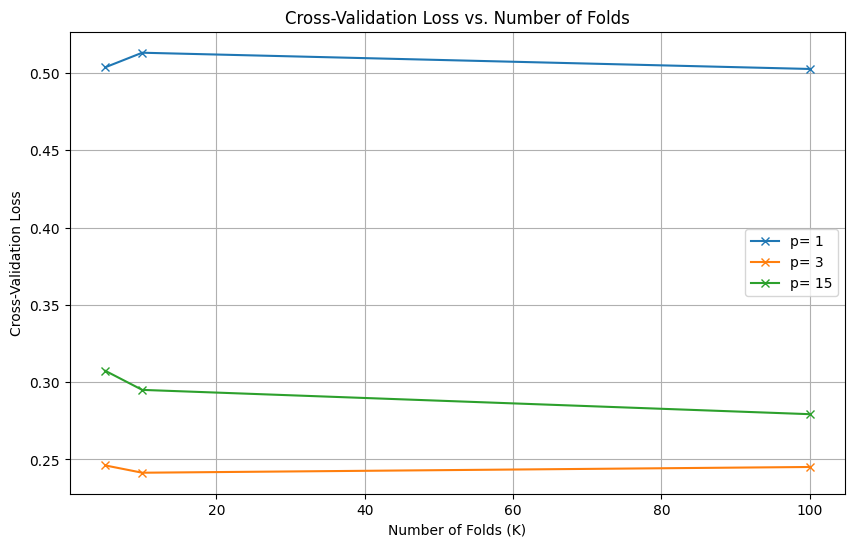

In [ ]:
# --- Experiment: Cross-Validation Behavior ---

u_cv, y_cv = generate_data(3, beta, sig, n)


K_vals = [5, 10, n] 
ps = [1, 3, 15]

X_cv = {}
cv_losses = {}

for p in ps:
    X_cv[p] = model_matrix(p, u_cv) 
    cv_losses[p] = {}
    for K in K_vals:
        cv_losses[p][K] = linear_cv(K, n, X_cv[p], y_cv) 

print("\nCross-Validation Loss:")

plt.figure(figsize=(10, 6))

for p in ps:
    K_values_plot = sorted(cv_losses[p].keys())
    cv_losses_plot = [cv_losses[p][K] for K in K_values_plot]
    plt.plot(K_values_plot, cv_losses_plot, marker='x', label=f'p= {p}')

plt.xlabel('Number of Folds (K)')
plt.ylabel('Cross-Validation Loss')
plt.title('Cross-Validation Loss vs. Number of Folds')
plt.legend()
plt.grid(True)
plt.show()

Model Selection: CV is the ideal tool for choosing the best polynomial degree (p). 

In scenarios like the initial one where p_true=3, the CV error should be lowest for p=3, correctly identifying the best model and flagging p=1 as underfitting and p=15 as overfitting due to their higher CV errors.

Number of Folds (K):

Small K (e.g., 5): 
The models are trained on slightly less data (e.g., 80% for K=5), so the error estimate might be slightly pessimistic (a bias-variance trade-off). It's computationally faster.

Large K (e.g., K=n, Leave-One-Out CV): 
This is computationally expensive but provides a nearly unbiased estimate of the generalization error. The training sets for each fold are very similar to the full dataset.

In practice, K=5 or K=10 is considered a good standard, balancing computational cost with a reliable performance estimate.


CV consistently identifies the "best" p for the given data, even in noisy or skewed scenarios, though the absolute CV loss values will reflect the difficulty of the task (e.g., higher for high sig, OOD, or skewed data).

For highly overfit models (p=15), the CV loss will be significantly higher than their training loss, effectively revealing their poor generalization capacity.